# ARIMA Model - using San Francisco Temperature data

In [1]:
%matplotlib inline

# import required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import scipy.stats as stats
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

from sklearn.metrics import mean_squared_error

sns.set()

DATA_PATH = "..\\data\\"

In [2]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [3]:
# read 'SF.csv'  dataset as a dataframe
SF = pd.read_csv(DATA_PATH + 'SF.csv', low_memory =  False)

# Convert index column to datetime dtype.
SF.datetime = pd.to_datetime(SF.datetime, infer_datetime_format = True)
SF.set_index('datetime', inplace = True)

# Only keep temperature attribute. drop rest of the columns.
SF_Temp = SF.drop(['Pressure', 'Humidity', 'Wind Speed'], axis = 1)

# Subtracting the seasonal component from the Temperature series
result = seasonal_decompose(SF_Temp.Temperature, model='additive')
SF_Temp.Temperature = SF_Temp.Temperature - result.seasonal

print(SF.shape)
print(SF.info(verbose = True, null_counts = True))

(44460, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44460 entries, 2012-10-01 13:00:00 to 2017-10-28 00:00:00
Data columns (total 5 columns):
Temperature       44460 non-null float64
Pressure          44460 non-null float64
Humidity          44460 non-null float64
Wind Speed        44460 non-null float64
Wind Direction    44460 non-null float64
dtypes: float64(5)
memory usage: 2.0 MB
None


In [4]:
# initialize a list to store test results
test_ar = []

### ARIMA Analysis

### Choosing the differencing order
Lets first plot the series. The plot below shows that series has yearly trend.
Lets draw logged series. The logged plot below seems to be more flat. The variations are really small as compared to the original series.

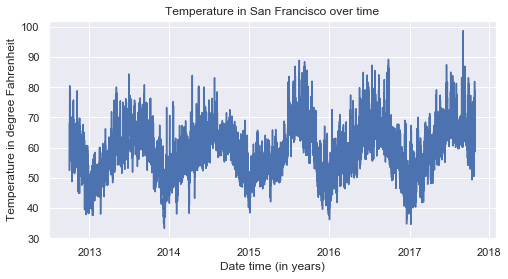

In [5]:
plt.rcParams["figure.figsize"] = [8,4]
SF_Temp.Temperature.plot()
plt.title('Temperature in San Francisco over time')
plt.ylabel('Temperature in degree Fahrenheit')
plt.xlabel('Date time (in years)')
plt.show()

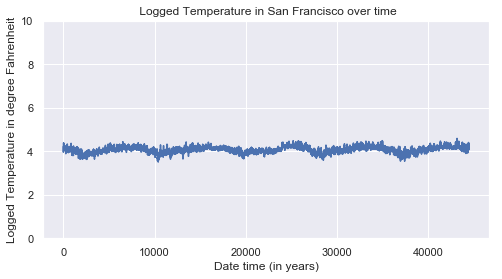

In [6]:
plt.rcParams["figure.figsize"] = [8,4]
plt.plot(np.log(SF_Temp.Temperature.values));
plt.title(' Logged Temperature in San Francisco over time')
plt.ylabel('Logged Temperature in degree Fahrenheit')
plt.xlabel('Date time (in years)')
plt.ylim(0,10)
plt.show()

######  KPSS Test - This test checks if the series is trend stationary
Since the test statistics is more than the critical values, we reject the null hypothesis. Which means that the series is not trend stationary. Since Series is not trend stationary, we will try the ACF and PACF plots for log series.
            The ACF plot of logged series shows that the lags are autocorrelated for bigger lags so the series is not trend stationary. So then it probably needs a higher order of differencing.  ACF plot of first order difference shows the bigger drop in values on first lag and fifth lag. So the order of Difference is either 1 or 5.

In [7]:
from statsmodels.tsa.stattools import kpss

print(" > Is the data stationary ?")
dftest = kpss(np.log(SF_Temp.Temperature), 'ct')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))

 > Is the data stationary ?
Test statistic = 0.741
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


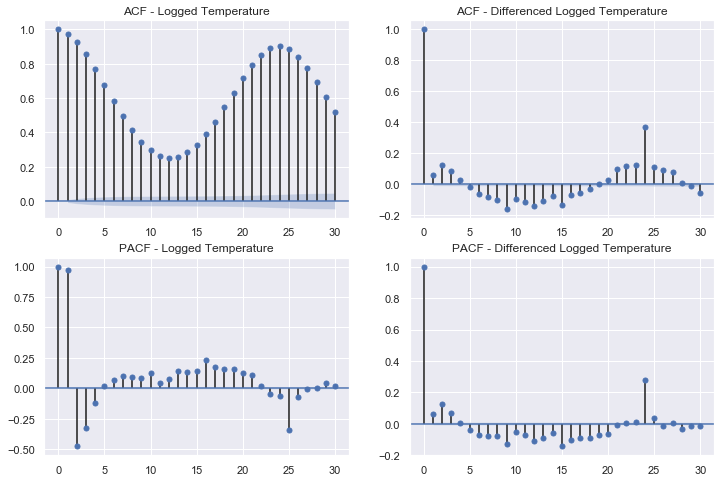

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
first_diff = (np.log(SF_Temp.Temperature)- np.log(SF_Temp.Temperature).shift()).dropna()
ax[0, 0] = plot_acf(np.log(SF.Temperature), ax=ax[0, 0], lags=30, title="ACF - Logged Temperature")
ax[1, 0] = plot_pacf(np.log(SF.Temperature), ax=ax[1, 0], lags=30, title="PACF - Logged Temperature")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=30, title="ACF - Differenced Logged Temperature")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=30, title="PACF - Differenced Logged Temperature")

### Choosing the MA order
The rule is: “ If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1”.
The Differenced ACF Logged plot above as sharp cutoof at lag 1. So we choose MA order as 1.

### Choosing the AR order
The rule is:“ If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1”.
The Differenced PACF Logged plot above as sharp cutoof at lag 1. So we choose AR order as 1.

In [9]:
# Accuracy metrics
def accuracy_metrics(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.sqrt(np.mean((forecast - actual)**2))  # RMSE
    print('Mean Absolute Percent Error ', mape, 'Mean Absolute Error', mae, 'Root Mean Square Error (rmse) ' , rmse)
    return mape, mae, rmse

### ARIMA (Auto-Regressive Integrated Moving Average) Model

In [10]:
# Create Training and Test datasets 
test_size = 10 # forecast for 6 hrs
training_size = SF.shape[0] - test_size

train = SF_Temp.iloc[:training_size, :]
test = SF_Temp.iloc[training_size:test_size +training_size, :]

In [11]:
# ARIMA model for (1,1,1)
test1 = test.copy()
history = [x for x in train.Temperature]
predictions = np.empty([test1.shape[0]])
AR_order = 1
I_order = 1
MA_order = 1
debug = []
print(test1.shape)
for t in range(test1.shape[0]):
    debug.append(t)
    AR_Model = ARIMA(np.log(history), order=(AR_order, I_order, MA_order))
    AR_Model_fit = AR_Model.fit(disp=0)
    output = AR_Model_fit.forecast()
    predictions[t] = output[0] #yhat
    history.append(test1.Temperature[t])
    del history[0]

test1['Predictions'] = np.exp(predictions)

mape, mae, rmse = accuracy_metrics(test1.Predictions, test1.Temperature)
test_ar.append({'label':'ARIMA', 'mape' : mape, 'mae': mae,'rmse':rmse})

(10, 2)
Mean Absolute Percent Error  0.025795833473738195 Mean Absolute Error 1.7271806791814683 Root Mean Square Error (rmse)  1.9886182575810367


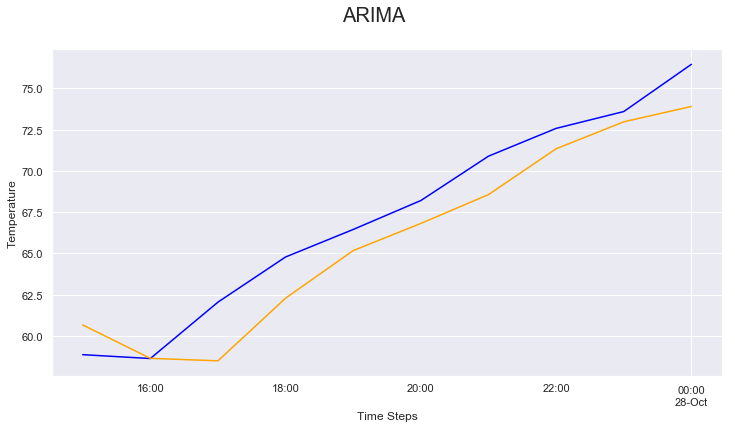

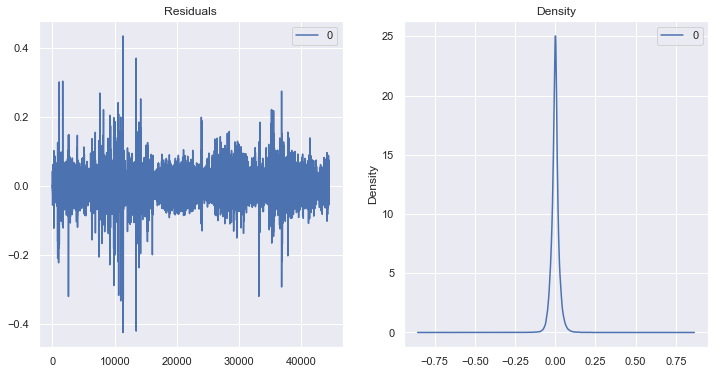

In [12]:
# Plot residual errors
plt.rcParams["figure.figsize"] = [12,6]
plt.suptitle("ARIMA ", fontsize=20)
test1.Temperature.plot(color = 'blue')
test1.Predictions.plot(color = 'orange')
plt.ylabel("Temperature")
plt.xlabel("Time Steps")
plt.show()

residuals = pd.DataFrame(AR_Model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [13]:
print(test_ar)

[{'label': 'ARIMA', 'mape': 0.025795833473738195, 'mae': 1.7271806791814683, 'rmse': 1.9886182575810367}]
